#### Image Augmentation
The data preprocessing pipeline is explained in the main notebook, but here I would like to show the difference
using the ImageDataAugmentation can really make to the accuracy of the network

In [6]:
import pickle
import numpy as np
import pandas as pd
import cv2
from sklearn.utils import class_weight
from scipy.misc import imread, imsave

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import seaborn as sns
sns.set_style("whitegrid")

In [5]:
from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Flatten, Dropout, Conv2D, MaxPooling2D
from keras import utils
from keras.callbacks import Callback, LambdaCallback, EarlyStopping, ModelCheckpoint
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta, Adam
from keras import backend as K
from keras.preprocessing import image
from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img


In [7]:
# please refer to the main notebook about the histogram normalisation process-- here I am loading the 
# normalised data to show the difference the image augmentation makes
X_train_hist_norm1 =np.load('data/X_train_hist_norm1.npy')
X_valid_hist_norm1 =np.load('data/X_valid_hist_norm1.npy')
X_test_hist_norm1 = np.load('data/X_test_hist_norm1.npy')

y_train_cat =np.load('data/y_train_cat.npy')
y_valid_cat =np.load('data/y_valid_cat.npy')
y_test_cat = np.load('data/y_ttest_cat.npy')

hist_norm_values = np.load('data/mean_hist_values.npy').item()

datagen = image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    shear_range=0.1,
    rotation_range=10.)

/Users/wwymak/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  from ipykernel import kernelapp as app


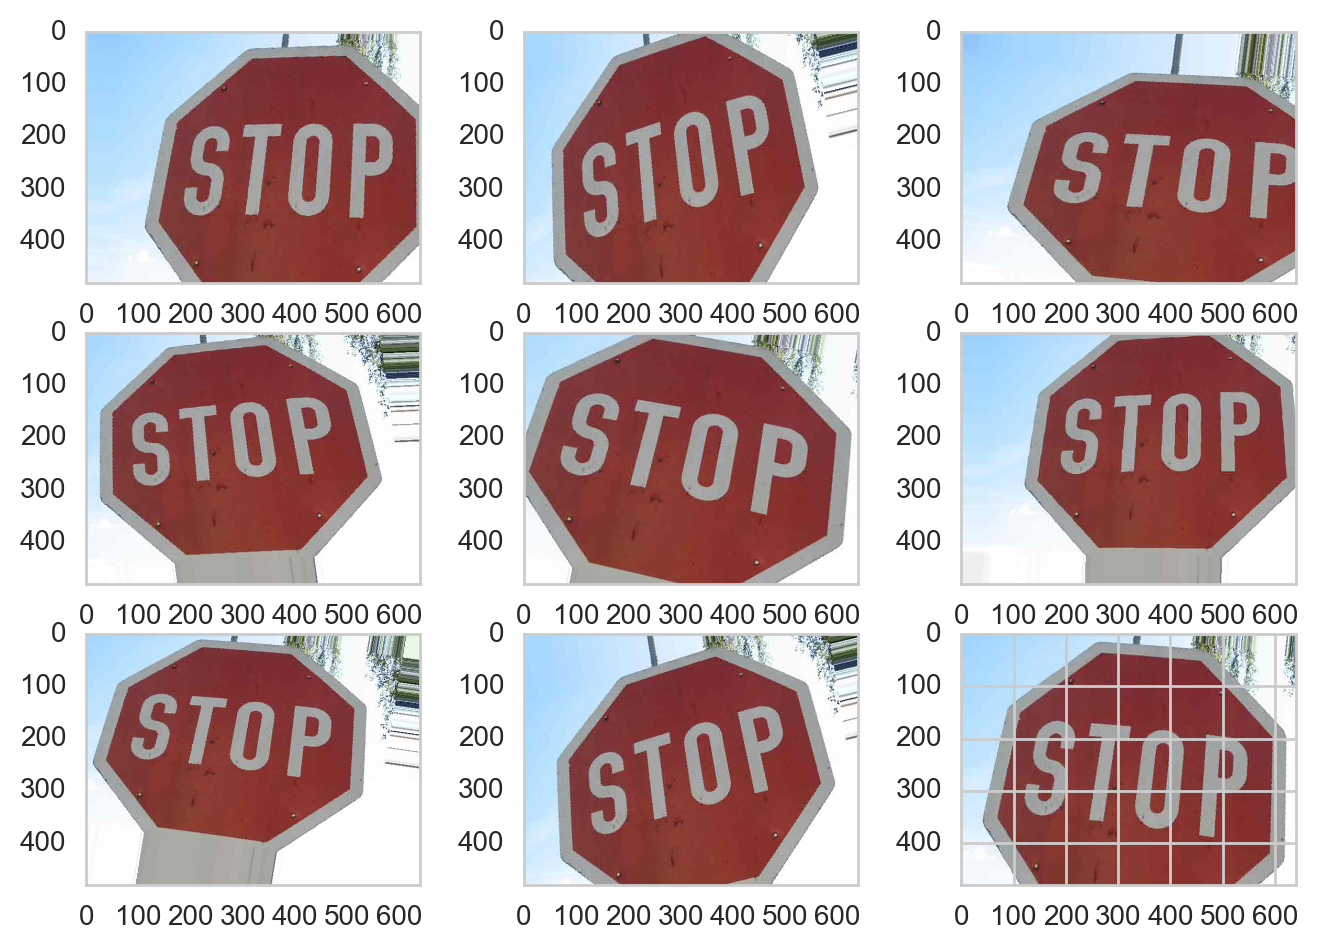

In [18]:
# a quick look at what the datagen does (here, I am not using the rest of the image preprocessing pipeline so as to simplify what the datagenerator does)
test_img =imread('data/traffic_sign14.jpg')
i = 0
for batch in datagen.flow(np.array([test_img]), batch_size=1,
                          save_to_dir='preview', save_prefix='stopsign', save_format='jpeg'):
    plt.grid(False)
    plt.subplot(3,3,i+1)
    plt.imshow(np.squeeze(batch).astype(np.uint8) )
    i += 1
    if i > 8:
        break
    

In [15]:
class_weight_arr = class_weight.compute_class_weight('balanced', np.unique(y_train), y_train)
class_weight_dict = {}
for i, val in enumerate(class_weight_arr) :
    class_weight_dict[i] = val
    
print(class_weight_dict)

{0: 4.4959948320413439, 1: 0.40872680291284941, 2: 0.40262640286937407, 3: 0.64228497600590628, 4: 0.45721981342793327, 5: 0.49047216349541933, 6: 2.2479974160206719, 7: 0.62734811609879215, 8: 0.64228497600590628, 9: 0.61309020436927408, 10: 0.44959948320413434, 11: 0.69169151262174522, 12: 0.42818998400393748, 13: 0.42149951550387599, 14: 1.1728682170542635, 15: 1.4986649440137811, 16: 2.2479974160206719, 17: 0.81745360582569881, 18: 0.74933247200689057, 19: 4.4959948320413439, 20: 2.6975968992248061, 21: 2.9973298880275623, 22: 2.4523608174770963, 23: 1.7983979328165374, 24: 3.3719961240310079, 25: 0.59946597760551246, 26: 1.4986649440137811, 27: 3.8537098560354375, 28: 1.685998062015504, 29: 3.3719961240310079, 30: 2.0750745378652353, 31: 1.1728682170542635, 32: 3.8537098560354375, 33: 1.3510501999456459, 34: 2.2479974160206719, 35: 0.74933247200689057, 36: 2.4523608174770963, 37: 4.4959948320413439, 38: 0.43509627406851714, 39: 2.9973298880275623, 40: 2.6975968992248061, 41: 3.853

In [16]:
def logger(epoch, logs):
    if epoch %2== 0: 
        print(epoch, logs['loss'], logs['acc'], logs['val_acc'])
logging_callback = LambdaCallback(
    on_epoch_end=logger)

stopping_callback = EarlyStopping(monitor='val_acc', min_delta= 0.001, patience=5)

In [17]:
def vggLike(ksize=(3,3), dropout=0.25): #taking my inspiration from vgg, a deeper network
    input_shape = (32,32,3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv1',input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=ksize, activation='relu', padding='same', name='set1_conv2'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2), name='set1_pool'))
    
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv1'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv2'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=ksize, activation='relu', padding='same', name='set2_conv3'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2),name='set2_pool'))

    model.add(Flatten())
    model.add(Dense(1024, activation='relu', name='fc1'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(512, activation='relu' , name='fc2'))
    model.add(BatchNormalization())
    model.add(Dropout(dropout))
    model.add(Dense(n_classes, activation='softmax', name='final'))
    model.compile(loss=categorical_crossentropy,
              optimizer=Adam(),
              metrics=['accuracy'])
    return model

In [36]:
vgglike.save('models/vgglike_hist_normed1')

In [39]:
score = vgglike.evaluate(X_test_hist_norm1, y_test_cat, verbose=0)
print(score)

[0.20368701582887203, 0.96476642915585265]


In [52]:
train_generator = datagenerator.flow(X_train_hist_norm1, y_train_cat)
validation_generator = valid_generator.flow(X_valid_hist_norm1, y_valid_cat)


In [28]:
# del vgglike
K.clear_session()
image_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3] )
batch_size = 32
epochs = 20
vgglike = vggLike(ksize=(3,3))

vgglike.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/vgglike_image_gen2.h5', save_best_only=True)
                              ])

# vgglike.fit_generator(
#     train_generator,
#     steps_per_epoch=len(X_train_hist_norm1) // batch_size,
#     epochs=epochs, 
#     verbose=0,shuffle=True, 
#     class_weight=class_weight_dict,
#     validation_data=validation_generator,
#     validation_steps=800 // batch_size,
#     callbacks=[logging_callback])

0 1.06402726292 0.689416362551 0.883446712397
2 0.183936847253 0.941061524784 0.965079365079
4 0.12060290602 0.962182821345 0.978458050076
6 0.0866339539031 0.972901520186 0.989115646259
8 0.0686426073648 0.978677548205 0.960317460507
10 0.0586404841519 0.981436248168 0.977097505669
12 0.0547620543993 0.983735164804 0.98752834486
14 0.044346064035 0.986752492888 0.987528344671
16 0.03654052597 0.988275525159 0.991383219955
18 0.0392438928912 0.987585850197 0.992743764172


In [29]:
print(vgglike.evaluate(X_test_hist_norm1, y_test_cat, verbose=0))

[0.11079416088137381, 0.97205067301966896]


In [30]:
epochs = 60
vgglike.fit_generator(datagen.flow(X_train_hist_norm1, y_train_cat, batch_size=batch_size),
                    steps_per_epoch=X_train_hist_norm1.shape[0],
                    epochs=epochs,
                      verbose=0,
                    validation_data=(X_valid_hist_norm1, y_valid_cat),
                    callbacks=[logging_callback,
                               ModelCheckpoint('models/vgglike_image_gen3.h5', save_best_only=True)
                              ])


0 0.0303572981815 0.990085922037 0.985487528345
2 0.0256590855101 0.991321589701 0.991836734694
4 0.0244580753975 0.992499784477 0.988888888889
6 0.0298349802263 0.990689387653 0.990022675737
8 0.0289730039021 0.991235380327 0.993424036281
10 0.0234103601955 0.992758412598 0.992290249622
12 0.0242696679092 0.992471048046 0.989115646259
14 0.0211164894733 0.993907870916 0.993650793651
16 0.0184709816037 0.993907870916 0.993197279101
18 0.0177420368183 0.994568809449 0.995238095238
20 0.0198395129052 0.994281444869 0.994557823129
22 0.0176456950333 0.994482600075 0.995464852608
24 0.0174676853557 0.994597545936 0.996145124717
26 0.0149277747416 0.99566079485 0.984580499055
28 0.0134316799115 0.995976895888 0.994557823129
30 0.0152622894274 0.995430903187 0.994784580499
32 0.0140344789819 0.995373430271 0.992290249433
34 0.012915414671 0.99609184172 0.994557823129
36 0.0132369597519 0.995833213598 0.992063492063
38 0.0148237850656 0.995143538635 0.99387755102
40 0.0130026365038 0.99623552